# Intro

In this approach, I decided to choose some different augmenting technique, called **_quarter erasing_**. The method is based on **_random erasing_** technique which is described in below paper: <br>

https://arxiv.org/pdf/1708.04896.pdf

In this technique, a quarter of an image will be erased randomly. For testing this method, I choose simpler model. which is a sequential model. You can see the network structure in image below. <br> 

<img src="https://github.com/amirfallah1988/Fashion-MNIST/blob/master/third_approach.png" title= "network structre"/> <br>

**Why choosing this structure** <br>
I chose this this augmentaion after reviewing the results of two last approaches and also train images. As also metioned in second approach, the main misclassification happend between shirts and T-shirts. To find some difference between these two classes and to train the network properly to distinguish between them, I try the technique of quarter erasing. By this technique, randomly the common parts of different classes may be removed and the model only trained by differnet parts of two model. For example it may removed up part of image which consists collar of shirt or t-shirt and keeps just sleeves, which is the main part of T-shirts and shirts.<br>

**Notes** <br>
- I use the simpler network to test my augmentation. We can combine this technique with network in pervious approaches.
- I tried to design a simple model with minimum parameters which also has good performance.<br>

## Importing modules

In [7]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import time

## Paramter setting

In [8]:
batch_size     = 64
nb_classes     = 10
nb_ephochs     = 100

## Load and prepare data
Here the fashion mnist dataset is loaded. The shape of dataset is proper (28x28), but for process with keras, need some modifications:<br>
**1-** The values of pixels are in range of 0-255. So it must normalize. For normalization I just divide each value by 255.<br>
**2-** The dimension of data must expand to 3.<br>
**3-** For use the data for classification task, I convert data's label to categorical form. <br>
**4-** Before divide -just for assurance- I shuffle the data.

In [9]:
# Load data
(All_data, All_labels), (x_test, y_test) = fashion_mnist.load_data()

# preprocess data

All_data=All_data/255
All_data=np.expand_dims(All_data, axis=3)
input_shape= (All_data.shape[1],All_data.shape[2],1)

All_labels_categorical=utils.to_categorical(All_labels, num_classes=nb_classes)

# shuffle data
p=np.random.permutation(len(All_data))
All_data=All_data[p]
All_labels_categorical=All_labels_categorical[p]


# prepare test data for further tests
x_test=x_test/255
x_test=np.expand_dims(x_test, axis=3)  
y_test_categorical=utils.to_categorical(y_test, num_classes=nb_classes)

## Data Augmentation
To improve the accuracy of model, I use quarter erasing augmentation techinque. We can use this technique beside other types of augmentation.

In [10]:
def quarter_erasing(image):
    q=np.random.randint(1,5)
    if q==1:
        image[:14,:14,:]=0
    if q==2:
        image[:14,14:,:]=0
    if q==3:
        image[14:,:14,:]=0
    if q==4:
        image[14:,14:,:]=0
    return image

Datagen=ImageDataGenerator(preprocessing_function=quarter_erasing)


## Sample of quarter erasing

(<matplotlib.image.AxesImage at 0x24a88d8a848>,
 Text(0.5, 1.0, 'quarter erasing result image'),
 (-0.5, 27.5, 27.5, -0.5))

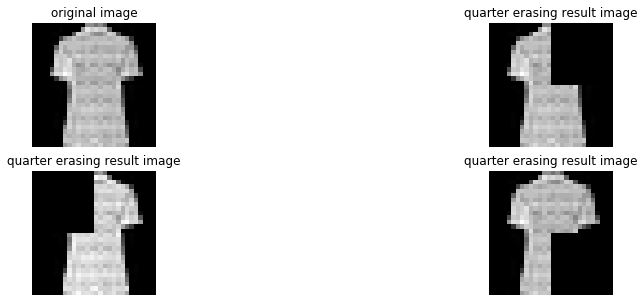

In [37]:
A=Datagen.flow(All_data[0:1],All_labels[0:1],batch_size=4)
result=A.next()[0]
fig=plt.figure(figsize=(15,5))
fig.add_subplot(2, 2, 1)
plt.imshow(All_data[0,:,:,0],cmap='gray'),plt.title('original image') , plt.axis('off')
fig.add_subplot(2, 2, 2)
plt.imshow(result[0,:,:,0],cmap='gray'),plt.title('quarter erasing result image')  ,plt.axis('off')
A=Datagen.flow(All_data[0:1],All_labels[0:1],batch_size=4)
result=A.next()[0]
fig.add_subplot(2, 2, 3)
plt.imshow(result[0,:,:,0],cmap='gray'),plt.title('quarter erasing result image')  ,plt.axis('off')
A=Datagen.flow(All_data[0:1],All_labels[0:1],batch_size=4)
result=A.next()[0]
fig.add_subplot(2, 2, 4)
plt.imshow(result[0,:,:,0],cmap='gray'),plt.title('quarter erasing result image')  ,plt.axis('off')



## Network structure
In the next cell, the structure of model is defined.

In [38]:
model=Sequential()

model.add(layers.Conv2D(32,kernel_size=3,padding='same',activation='relu',input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,padding='same'))
model.add(layers.Conv2D(32,kernel_size=3,padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(.4))
# model.add(layers.Dense(30,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)             

## Optimizer, loss and metric
Based on my own experience and also after test SGD optimzers, I choosed ADAM optimzer with learning rate equal to 0.001.<br>
I also tested both MSE and categorical crossentropy as loss function and as I expected the categorical cross entropy was the better choice.<br>
For metric, I choose accuracy, just to find out number of correct prediction.

In [39]:
optimizer=optimizers.Adam(learning_rate=0.001)
loss=losses.CategoricalCrossentropy()
metric=metrics.Accuracy()

## Callbacks
I use three callbacks to handle the procedure of learning: <br>
**1-** Checkpoint model: to save the best model in learning procedure. <br>
**2-** Reduce learning rate in plateau: to decay the learning rate when the loss value get stuck in plateau. <br>
**3-** Early stopping: to prevenet overfitting and also to shorten the time of the training, I used early stopping callback.<br>

In [40]:
es=callbacks.EarlyStopping(min_delta=0.0001, patience=5,restore_best_weights=True)
mc=callbacks.ModelCheckpoint('third_approach_model.hdf5',save_best_only=True)
rop=callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=4 , min_delta=0.01,verbose=1)

## Train the model
**Note** <br>
**_- Cross validation techniques can be used in evaluating the performance of the model, but to hold the process succinct I didn't use it._** <br>
**- The data was splited to train and validation for evaluate the performance.**

In [41]:
# split data to train and validation
x_train,x_val,y_train_categorical,y_val_categorical=train_test_split(All_data,All_labels_categorical,test_size=.1)


# compile

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train
start_time=time.time()
h=model.fit_generator(Datagen.flow(x_train, y_train_categorical, batch_size=batch_size),
            steps_per_epoch=round(len(x_train) / batch_size),
            epochs = nb_ephochs,
                validation_data=(x_val, y_val_categorical),
            # validation_split=.15 ,
            callbacks=[mc,rop,es],verbose=1
            )
train_time=time.time()-start_time



   

Epoch 1/100
844/844 [==============================] - 145s 172ms/step - loss: 0.5889 - accuracy: 0.7899 - val_loss: 0.3760 - val_accuracy: 0.8702
Epoch 2/100
844/844 [==============================] - 148s 175ms/step - loss: 0.4021 - accuracy: 0.8535 - val_loss: 0.2701 - val_accuracy: 0.9035
Epoch 3/100
844/844 [==============================] - 148s 175ms/step - loss: 0.3561 - accuracy: 0.8704 - val_loss: 0.2573 - val_accuracy: 0.9047
Epoch 4/100
844/844 [==============================] - 147s 174ms/step - loss: 0.3284 - accuracy: 0.8797 - val_loss: 0.2481 - val_accuracy: 0.9123
Epoch 5/100
844/844 [==============================] - 150s 178ms/step - loss: 0.3074 - accuracy: 0.8880 - val_loss: 0.2528 - val_accuracy: 0.9077
Epoch 6/100
844/844 [==============================] - 141s 167ms/step - loss: 0.2937 - accuracy: 0.8933 - val_loss: 0.2328 - val_accuracy: 0.9200
Epoch 7/100
844/844 [==============================] - 159s 188ms/step - loss: 0.2779 - accuracy: 0.8970 - val_loss: 0

## Plotting results of train
The plots below shows the accuracy and loss changes in each epoch, respectively.

([<matplotlib.lines.Line2D at 0x24a881d1a08>],
 Text(0.5, 0, 'epoch'),
 Text(0, 0.5, 'loss'),
 Text(0.5, 1.0, 'Validation Plot'))

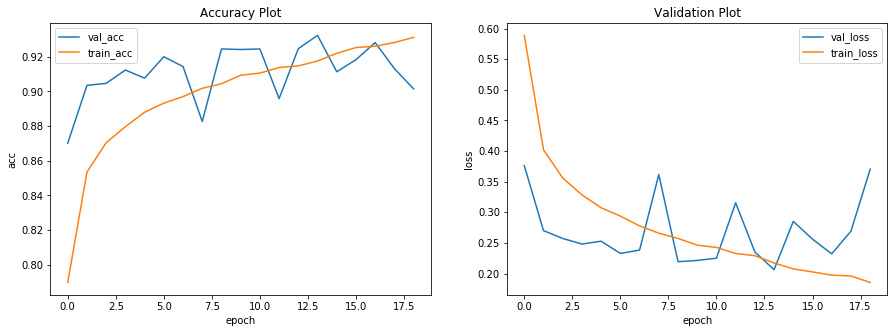

In [42]:
val_acc_logs=model.history.history['val_accuracy']
val_loss_logs=model.history.history['val_loss']


acc_logs=model.history.history['accuracy']
loss_logs=model.history.history['loss']

fig=plt.figure(figsize=(15,5))
fig.add_subplot(1, 2, 1)
plt.plot(val_acc_logs),plt.plot(acc_logs), plt.xlabel('epoch'), plt.ylabel('acc'),plt.legend(['val_acc','train_acc']),plt.title('Accuracy Plot')
fig.add_subplot(1, 2, 2)
plt.plot(val_loss_logs),plt.plot(loss_logs), plt.xlabel('epoch'), plt.ylabel('loss'),plt.legend(['val_loss','train_loss']),plt.title('Validation Plot')


## Time complexity of model
we print here the time of just one fit procedure (not whole kfold procedure). Note that the early stopping can change the time of procedure.<br>
**Note that this time is taken on the cpu, not gpu.**

In [43]:
print ('The estimatd time for train the model:  {}  (seconds)'.format(train_time))

The estimatd time for train the model:  2771.433980703354  (seconds)


## Apply model on test data
Now its time to apply the model on test dataset to see whether the result is promising or not.

In [44]:
result=model.predict(x_test)
result=np.argmax(result,axis=1)
loss_test,acc_test=model.evaluate(x_test,y_test_categorical,verbose=0)
print ('test_accuracy, {:00.3f} '.format(acc_test))
print ('test_loss, {:00.3f}'.format(loss_test))

test_accuracy, 0.918 
test_loss, 0.266


## Confusion Matrix
Here is the confusion matrix of test data to consider the results more precise.

In [45]:
conf_mat=confusion_matrix(y_test, result)
indexes=pd.Index(['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'])
Table=pd.DataFrame(conf_mat,index=indexes,columns=indexes)
Table

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,895,1,13,12,4,1,73,0,1,0
Trouser,0,985,0,9,2,0,2,0,2,0
Pullover,14,1,887,9,44,0,45,0,0,0
Dress,13,6,4,935,19,0,23,0,0,0
Coat,0,0,81,29,844,0,45,0,1,0
Sandal,0,0,0,0,0,982,0,9,1,8
Shirt,107,3,59,30,70,0,728,0,3,0
Sneaker,0,0,0,0,0,6,0,971,0,23
Bag,2,1,2,5,3,0,6,1,980,0
Ankle boot,0,0,0,0,0,4,1,20,0,975


## Conclusion


In [46]:
stat_indexes=pd.Index(['Num_layers','Num_parameters','Total train_time','Accuracy'])
stat_table=pd.DataFrame([],index=stat_indexes)
stat_table.loc['Num_layers','value']=len(model.layers)
stat_table.loc['Num_parameters','value']=model.count_params()
stat_table.loc['Total train_time','value']=round(train_time,2)
stat_table.loc['Accuracy','value']=round(acc_test*100,2)
stat_table

,value
Num_layers,10.00
Num_parameters,211946.00
Total train_time,2771.43
Accuracy,91.82
